In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1: installs & imports
!pip install -q rapidfuzz

import os, re, unicodedata
from pathlib import Path
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from tqdm.auto import tqdm

pd.set_option('display.max_colwidth', 200)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.6 MB/s eta 0:00:00


In [3]:
# Cell 2: load CSVs (update paths if necessary)
base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"

paths = {
    'main': f"{base}/chemicals-in-cosmetics.csv",
    'prop65': f"{base}/proposition65_clean.csv",
    'iarc': f"{base}/List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv",
    'toxcast': f"{base}/Chemical List toxcast-2025-08-08.csv",
    'cosing': f"{base}/coslng/COSING_Ingredients-Fragrance Inventory_v2.csv"
}

for k,p in paths.items():
    print(k, "->", p, "exists?", Path(p).exists())

# Read with robust options
main_df = pd.read_csv(paths['main'], low_memory=False)
prop65_df = pd.read_csv(paths['prop65'], low_memory=False)
iarc_df = pd.read_csv(paths['iarc'], low_memory=False)
toxcast_df = pd.read_csv(paths['toxcast'], low_memory=False)
cosing_df = pd.read_csv(paths['cosing'], low_memory=False)

print("\nShapes:")
print("main", main_df.shape)
print("prop65", prop65_df.shape)
print("iarc", iarc_df.shape)
print("toxcast", toxcast_df.shape)
print("cosing", cosing_df.shape)

print("\nmain columns:")
print(main_df.columns.tolist())
main_df.head(3)


main -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics.csv exists? True
prop65 -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/proposition65_clean.csv exists? True
iarc -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv exists? True
toxcast -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/Chemical List toxcast-2025-08-08.csv exists? True
cosing -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Ingredients-Fragrance Inventory_v2.csv exists? True

Shapes:
main (112870, 22)
prop65 (1038, 6)
iarc (1121, 7)
toxcast (4746, 14)
cosing (30080, 10)

main columns:
['CDPHId', 'ProductName', 'CSFId', 'CSF', 'CompanyId', 'CompanyName', 'BrandName', 'PrimaryCategoryId', 'PrimaryCategory', 'SubCategoryId', 'SubCategory', 'CasId', 'CasNumber', 'ChemicalId', 'ChemicalName', 'InitialDateReported', 'MostRecentDa

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1
1,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,65996-92-1,4,Distillates (coal tar),07/01/2009,07/01/2009,NaN,07/01/2009,07/01/2009,NaN,2
2,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,140-67-0,5,Estragole,07/01/2009,07/01/2009,NaN,07/02/2009,07/02/2009,NaN,2


In [4]:
# Cell 3: detect common column names (CAS, chemical name, product, brand)
def find_col(df, candidates):
    cols = df.columns.tolist()
    lookup = {c.lower(): c for c in cols}
    for cand in candidates:
        low = cand.lower()
        # direct substring match
        for col in cols:
            if low in col.lower():
                return col
    # fallback: exact match ignoring case
    for col in cols:
        if col.lower() in [c.lower() for c in candidates]:
            return col
    return None

chem_name_candidates = ['ChemicalName','Chemical Name','chemical_name','Ingredient','IngredientName','Ingredient Name','INCI_Name','Chemical']
cas_candidates = ['CASNumber','CAS Number','CAS','CAS_No','CAS_Number','RN','Registry Number']
product_candidates = ['Product','ProductName','Product Name','Product_Label','ProductLabel','Product Description','Product_Description','Product Name / Product']
brand_candidates = ['Brand','BrandName','Company','CompanyName','Manufacturer','Company Name']

chem_col = find_col(main_df, chem_name_candidates)
cas_col = find_col(main_df, cas_candidates)
prod_col = find_col(main_df, product_candidates)
brand_col = find_col(main_df, brand_candidates)

print("Detected columns:")
print("chemical column:", chem_col)
print("CAS column:", cas_col)
print("product column:", prod_col)
print("brand column:", brand_col)

# show sample of chosen columns
sample_cols = [c for c in [prod_col, brand_col, chem_col, cas_col] if c]
main_df[sample_cols].head(6)


Detected columns:
chemical column: ChemicalName
CAS column: CasNumber
product column: ProductName
brand column: BrandName


,ProductName,BrandName,ChemicalName,CasNumber
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,AVON,Titanium dioxide,13463-67-7
1,Glover's Medicated Shampoo,Glover's,Distillates (coal tar),65996-92-1
2,Glover's Medicated Shampoo,Glover's,Estragole,140-67-0
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,AVON,Titanium dioxide,13463-67-7
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,AVON,Titanium dioxide,13463-67-7
5,JILLIAN DEMPSEY FOR AVON CELESTIAL EYESHADOW-ALL SHADES �,AVON,Titanium dioxide,13463-67-7


In [5]:
# Cell 4: normalization helpers
import string

def normalize_text(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = s.strip()
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))  # remove accents
    s = s.lower()
    # keep basic punctuation (commas, parentheses, -) for now
    s = re.sub(r'[^a-z0-9\-\.,\(\)\/\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip()
    return s

cas_re = re.compile(r'(\d{1,7}\-\d{1,2}\-\d{1})')

def extract_cas(s):
    """Return the first CAS-like token or empty string."""
    if pd.isna(s): return ""
    s = str(s)
    m = cas_re.search(s)
    if m:
        return m.group(1)
    # sometimes CAS without dashes? try to find by pattern of digits
    return ""


In [6]:
# Cell 5: build chemical-level df from main dataset rows
# Uses detected chem_col / cas_col; if not found, try common column names
if chem_col is None:
    raise ValueError("Couldn't auto-detect chemical name column in main CSV. Check column names above.")

main = main_df.copy()
main['_chem_raw'] = main[chem_col].astype(str)
main['_chem_norm'] = main['_chem_raw'].apply(normalize_text)
main['_cas_raw'] = ""
if cas_col is not None:
    main['_cas_raw'] = main[cas_col].astype(str)
main['_cas'] = main['_cas_raw'].apply(extract_cas)
main['_cas'] = main['_cas'].replace({'': None})

chem_unique = (main[['_chem_raw','_chem_norm','_cas']]
               .drop_duplicates()
               .rename(columns={'_chem_raw':'chemical_name_raw','_chem_norm':'chemical_name_norm','_cas':'cas'}))
chem_unique = chem_unique.reset_index(drop=True)
print("Unique chemical rows from main file:", chem_unique.shape[0])
chem_unique.head(10)


Unique chemical rows from main file: 157


,chemical_name_raw,chemical_name_norm,cas
0,Titanium dioxide,titanium dioxide,13463-67-7
1,Distillates (coal tar),distillates (coal tar),65996-92-1
2,Estragole,estragole,140-67-0
3,Cocamide diethanolamine,cocamide diethanolamine,68603-42-9
4,Toluene,toluene,108-88-3
5,Cocamide diethanolamine,cocamide diethanolamine,None
6,Chromium (hexavalent compounds),chromium (hexavalent compounds),None
7,Retinol,retinol,68-26-8
8,"Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.","retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",79-81-2
9,Vitamin A,vitamin a,11103-57-4


In [7]:
# Cell 6: normalize authoritative sources (prop65, iarc, toxcast, cosing)
def auto_find_name_and_cas(df):
    name = find_col(df, ['Name','ChemicalName','Chemical Name','INCI','Substance','Substance_Name'])
    cas = find_col(df, ['CASNumber','CAS Number','CAS','RN','Registry Number','EC_Number','EC Number'])
    return name, cas

# Prop65
p65_name_col, p65_cas_col = auto_find_name_and_cas(prop65_df)
print("Prop65 name col:", p65_name_col, "CAS col:", p65_cas_col)
prop65_df['_name_norm'] = prop65_df[p65_name_col].astype(str).apply(normalize_text) if p65_name_col else ""
prop65_df['_cas'] = prop65_df[p65_cas_col].astype(str).apply(extract_cas) if p65_cas_col else None
prop65_names = set(prop65_df['_name_norm'].dropna().unique())
prop65_cas = set([x for x in prop65_df['_cas'].dropna().unique() if x])

# IARC
iarc_name_col, iarc_cas_col = auto_find_name_and_cas(iarc_df)
print("IARC name col:", iarc_name_col, "CAS col:", iarc_cas_col)
iarc_df['_name_norm'] = iarc_df[iarc_name_col].astype(str).apply(normalize_text) if iarc_name_col else ""
iarc_df['_cas'] = iarc_df[iarc_cas_col].astype(str).apply(extract_cas) if iarc_cas_col else None
iarc_names = set(iarc_df['_name_norm'].dropna().unique())
iarc_cas = set([x for x in iarc_df['_cas'].dropna().unique() if x])

# ToxCast
tox_name_col, tox_cas_col = auto_find_name_and_cas(toxcast_df)
print("ToxCast name col:", tox_name_col, "CAS col:", tox_cas_col)
toxcast_df['_name_norm'] = toxcast_df[tox_name_col].astype(str).apply(normalize_text) if tox_name_col else ""
toxcast_df['_cas'] = toxcast_df[tox_cas_col].astype(str).apply(extract_cas) if tox_cas_col else None
tox_names = set(toxcast_df['_name_norm'].dropna().unique())
tox_cas = set([x for x in toxcast_df['_cas'].dropna().unique() if x])

# CosIng: canonical names and CAS
cosing_name_col, cosing_cas_col = auto_find_name_and_cas(cosing_df)
print("CosIng name col:", cosing_name_col, "CAS col:", cosing_cas_col)
cosing_df['_name_norm'] = cosing_df[cosing_name_col].astype(str).apply(normalize_text) if cosing_name_col else ""
cosing_df['_cas'] = cosing_df[cosing_cas_col].astype(str).apply(extract_cas) if cosing_cas_col else None
cosing_names = set(cosing_df['_name_norm'].dropna().unique())
cosing_cas = set([x for x in cosing_df['_cas'].dropna().unique() if x])

print("\nSizes:")
print("prop65 names/cas:", len(prop65_names), len(prop65_cas))
print("iarc names/cas:", len(iarc_names), len(iarc_cas))
print("tox names/cas:", len(tox_names), len(tox_cas))
print("cosing names/cas:", len(cosing_names), len(cosing_cas))


Prop65 name col: None CAS col: CAS No.
IARC name col: None CAS col: CAS No.
ToxCast name col: PREFERRED NAME CAS col: CASRN
CosIng name col: INCI name CAS col: CAS No

Sizes:
prop65 names/cas: 1 788
iarc names/cas: 1 875
tox names/cas: 4746 4653
cosing names/cas: 30079 10349


In [8]:
# Cell 7: exact-match labeling using CAS (preferred) and normalized names (fallback)
chem = chem_unique.copy()
chem['label_prop65_exact_cas'] = chem['cas'].isin(prop65_cas)
chem['label_iarc_exact_cas'] = chem['cas'].isin(iarc_cas)
chem['label_toxcast_exact_cas'] = chem['cas'].isin(tox_cas)

chem['label_prop65_exact_name'] = chem['chemical_name_norm'].isin(prop65_names)
chem['label_iarc_exact_name'] = chem['chemical_name_norm'].isin(iarc_names)
chem['label_toxcast_exact_name'] = chem['chemical_name_norm'].isin(tox_names)

# combined exact flags
chem['flag_exact_any'] = chem[['label_prop65_exact_cas','label_iarc_exact_cas','label_toxcast_exact_cas',
                              'label_prop65_exact_name','label_iarc_exact_name','label_toxcast_exact_name']].any(axis=1)

print("Exact matches found:", chem['flag_exact_any'].sum(), "out of", len(chem))
chem.head(10)


Exact matches found: 86 out of 157


,chemical_name_raw,chemical_name_norm,cas,label_prop65_exact_cas,label_iarc_exact_cas,label_toxcast_exact_cas,label_prop65_exact_name,label_iarc_exact_name,label_toxcast_exact_name,flag_exact_any
0,Titanium dioxide,titanium dioxide,13463-67-7,False,True,False,False,False,False,True
1,Distillates (coal tar),distillates (coal tar),65996-92-1,False,False,False,False,False,False,False
2,Estragole,estragole,140-67-0,True,False,True,False,False,True,True
3,Cocamide diethanolamine,cocamide diethanolamine,68603-42-9,False,True,False,False,False,False,True
4,Toluene,toluene,108-88-3,True,True,False,False,False,False,True
5,Cocamide diethanolamine,cocamide diethanolamine,None,False,False,False,False,False,False,False
6,Chromium (hexavalent compounds),chromium (hexavalent compounds),None,False,False,False,False,False,False,False
7,Retinol,retinol,68-26-8,False,False,True,False,False,True,True
8,"Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.","retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",79-81-2,False,False,True,False,False,False,True
9,Vitamin A,vitamin a,11103-57-4,False,False,False,False,False,False,False


In [9]:
# Cell 8: fuzzy-match remaining chemical names (only for names without exact cas matches)
# Build a combined authoritative name list (we'll use prop65 + iarc + tox + cosing names)
auth_names = list((prop65_names | iarc_names | tox_names | cosing_names))
print("Auth name list length:", len(auth_names))

def fuzzy_map_name(name, choices, score_cutoff=90):
    if not name or name.strip()=='':
        return None, 0
    match = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= score_cutoff:
        return match[0], match[1]
    return None, 0

# apply fuzzy matching only for rows not flagged by exact CAS or exact name
to_fuzzy = chem[~chem['flag_exact_any']].copy()
print("To fuzzy-match:", len(to_fuzzy))

fuzzy_matches = []
for idx, row in tqdm(to_fuzzy.iterrows(), total=len(to_fuzzy)):
    nm = row['chemical_name_norm']
    best_name, score = fuzzy_map_name(nm, auth_names, score_cutoff=88)  # 88 threshold; adjust if needed
    fuzzy_matches.append((idx, best_name, score))

fuzzy_df = pd.DataFrame(fuzzy_matches, columns=['idx','fuzzy_match_name','fuzzy_score']).set_index('idx')
chem = chem.join(fuzzy_df, how='left')

# mark fuzzy-based flags
chem['label_fuzzy_any'] = chem['fuzzy_match_name'].notna()
print("Fuzzy matched:", chem['label_fuzzy_any'].sum())

# final tentative flag: exact OR fuzzy
chem['flag_any'] = chem['flag_exact_any'] | chem['label_fuzzy_any']
chem['matching_source'] = np.where(chem['flag_exact_any'], 'exact',
                           np.where(chem['label_fuzzy_any'], 'fuzzy','none'))

chem[['chemical_name_raw','cas','flag_exact_any','label_fuzzy_any','fuzzy_match_name','fuzzy_score','matching_source']].sample(10)


Auth name list length: 34331
To fuzzy-match: 71


  0%|          | 0/71 [00:00<?, ?it/s]

Fuzzy matched: 24


,chemical_name_raw,cas,flag_exact_any,label_fuzzy_any,fuzzy_match_name,fuzzy_score,matching_source
77,Vitamin A palmitate,79-91-2,False,False,None,0.000000,none
38,Genistein (purified),446-72-0,True,False,NaN,NaN,exact
68,Coal tars,None,False,True,coal tar,94.117647,fuzzy
93,Mercury and mercury compounds,7439-97-6,True,False,NaN,NaN,exact
49,o-Phenylenediamine and its salts,95-54-5,True,False,NaN,NaN,exact
63,Propylene oxide,75-56-9,True,False,NaN,NaN,exact
155,Bisphenol A (BPA),80-05-7,True,False,NaN,NaN,exact
87,Cocamide diethanolamine,61791-31-9,False,False,None,0.000000,none
141,Isopropyl alcohol manufacture using strong acids,None,False,False,None,0.000000,none
10,Vitamin A palmitate,79-81-2,True,False,NaN,NaN,exact


In [10]:
# Cell 9: summary counts
total_chem = len(chem)
exact = chem['flag_exact_any'].sum()
fuzzy = chem['label_fuzzy_any'].sum()
both = chem['flag_any'].sum()
print(f"Total chemicals: {total_chem:,}")
print(f"Exact matches: {exact:,}")
print(f"Fuzzy matches (new): {fuzzy:,}")
print(f"Total flagged (exact or fuzzy): {both:,}")

# show top flagged chemicals (by how many times they appear in main product rows)
# first join counts from main df
counts = main.groupby(['_chem_norm']).size().reset_index(name='occurrences')
counts = counts.rename(columns={'_chem_norm':'chemical_name_norm'})
chem = chem.merge(counts, how='left', on='chemical_name_norm')
chem['occurrences'] = chem['occurrences'].fillna(0).astype(int)
chem.sort_values(['flag_any','occurrences'], ascending=[False, False]).head(20)


Total chemicals: 157
Exact matches: 86
Fuzzy matches (new): 24
Total flagged (exact or fuzzy): 110


,chemical_name_raw,chemical_name_norm,cas,label_prop65_exact_cas,label_iarc_exact_cas,label_toxcast_exact_cas,label_prop65_exact_name,label_iarc_exact_name,label_toxcast_exact_name,flag_exact_any,fuzzy_match_name,fuzzy_score,label_fuzzy_any,flag_any,matching_source,occurrences
0,Titanium dioxide,titanium dioxide,13463-67-7,False,True,False,False,False,False,True,NaN,NaN,False,True,exact,92304
17,Titanium dioxide,titanium dioxide,None,False,False,False,False,False,False,False,titanium dioxide,100.0,True,True,fuzzy,92304
30,Titanium dioxide,titanium dioxide,1317-70-0,False,False,False,False,False,False,False,titanium dioxide,100.0,True,True,fuzzy,92304
73,Titanium dioxide,titanium dioxide,98084-96-9,False,False,False,False,False,False,False,titanium dioxide,100.0,True,True,fuzzy,92304
102,Titanium dioxide,titanium dioxide,1317-80-2,False,False,False,False,False,False,False,titanium dioxide,100.0,True,True,fuzzy,92304
8,"Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.","retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",79-81-2,False,False,True,False,False,False,True,NaN,NaN,False,True,exact,2154
115,"Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.","retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",68-26-8,False,False,True,False,False,False,True,NaN,NaN,False,True,exact,2154
11,Butylated hydroxyanisole,butylated hydroxyanisole,25013-16-5,True,True,True,False,False,True,True,NaN,NaN,False,True,exact,1882
31,Mica,mica,12001-26-2,False,False,False,False,False,False,False,mica,100.0,True,True,fuzzy,1839
19,Carbon black,carbon black,1333-86-4,True,True,False,False,False,False,True,NaN,NaN,False,True,exact,1717


In [11]:
# Cell 10: product-level aggregation
# Build a product identifier. Use prod_col if found, else combine brand + row index
if prod_col:
    main['_product_name'] = main[prod_col].astype(str)
else:
    main['_product_name'] = main.index.astype(str)

if brand_col:
    main['_brand'] = main[brand_col].astype(str)
else:
    main['_brand'] = ''

# attach chemical flags by joining on normalized chemical name (and CAS if available)
chem_lookup = chem[['chemical_name_norm','cas','flag_any']].copy()
chem_lookup = chem_lookup.rename(columns={'chemical_name_norm':'_chem_norm','flag_any':'chemical_flagged'})
main2 = main.merge(chem_lookup, left_on='_chem_norm', right_on='_chem_norm', how='left')
main2['chemical_flagged'] = main2['chemical_flagged'].fillna(False)

# aggregate per product (product defined by brand + product name to reduce collisions)
main2['_product_id'] = (main2['_brand'].fillna('') + "||" + main2['_product_name'].fillna('')).astype(str)

agg = main2.groupby('_product_id').agg(
    product_name = ('_product_name','first'),
    brand = ('_brand','first'),
    num_ingredients = ('_chem_norm','nunique'),
    count_flagged = ('chemical_flagged','sum')
).reset_index()

agg['fraction_flagged'] = agg['count_flagged'] / agg['num_ingredients'].replace(0, np.nan)
agg['product_label'] = (agg['count_flagged'] > 0).astype(int)

print("Products aggregated:", len(agg))
display(agg.head(10))

Products aggregated: 34796


,_product_id,product_name,brand,num_ingredients,count_flagged,fraction_flagged,product_label
0,Anastasia Beverly HIlls||Perfect Brow Pencil (Granite shade_,Perfect Brow Pencil (Granite shade_,Anastasia Beverly HIlls,1,5,5.0,1
1,Entity Nudite||Cool Pink Nail Sculpting Powder,Cool Pink Nail Sculpting Powder,Entity Nudite,1,5,5.0,1
2,"Gap Outlet||Light Pink, lip gloss (Lip trio)","Light Pink, lip gloss (Lip trio)",Gap Outlet,1,5,5.0,1
3,Hard Candy||Fierce Effects- Shadow Duo,Fierce Effects- Shadow Duo,Hard Candy,1,100,100.0,1
4,Innisfree ||Innisfree My Lip Balm 05 Wild Hibiscus,Innisfree My Lip Balm 05 Wild Hibiscus,Innisfree,1,5,5.0,1
5,Laneige ||BB Cushion Pore Blur No.11 Porcelain,BB Cushion Pore Blur No.11 Porcelain,Laneige,1,10,10.0,1
6,Mary Kay ||Blonde Mechanical Brow Pencil,Blonde Mechanical Brow Pencil,Mary Kay,1,10,10.0,1
7,Mary Kay ||Cream Blush,Cream Blush,Mary Kay,1,20,20.0,1
8,Mary Kay ||Cream Eye Color,Cream Eye Color,Mary Kay,1,40,40.0,1
9,Mary Kay ||True Dimensions Lipstick,True Dimensions Lipstick,Mary Kay,1,115,115.0,1


In [12]:
# Cell 11: quick snapshot of flagged products and save outputs
print("Flagged product examples:")
display(agg[agg['product_label']==1].sample(min(10, agg['product_label'].sum()))[['brand','product_name','num_ingredients','count_flagged','fraction_flagged']])

# Save chemical labels and product aggregate to Drive
out_dir = Path(base) / "processed"
out_dir.mkdir(parents=True, exist_ok=True)
chem.to_csv(out_dir / "chemical_labels_from_main.csv", index=False)
agg.to_csv(out_dir / "product_level_flags.csv", index=False)

print("Saved:", out_dir / "chemical_labels_from_main.csv")
print("Saved:", out_dir / "product_level_flags.csv")


Flagged product examples:


,brand,product_name,num_ingredients,count_flagged,fraction_flagged
18892,Lush Handmade Cosmetics,Prince Charming,1,5,5.0
26629,Rimmel - London,Rimmel - London SPARK IT UP Gleaming Eye Darkener,1,25,25.0
26037,Revlon,Illuminance Creme Shadow- Copper Canyon- bronzed brown 28,1,5,5.0
12013,Fillerina,Day Cream Grade 1/Day Cream Grade 2/Day Cream Grade 3,1,1,1.0
17016,Kroger,Medicated Shampoo,1,2,2.0
15544,Innisfree,Innisfree My Eyeshadow [Shimmer] 9,1,5,5.0
17571,L'Oreal,L'Oreal True Match Concealer,1,45,45.0
15895,Innisfree,real fit lipstick 12,1,5,5.0
26041,Revlon,Illuminance Creme Shadow- Khaki Suede- pale green 11,1,5,5.0
15767,Innisfree,my blusher 7,1,5,5.0


Saved: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/chemical_labels_from_main.csv
Saved: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/product_level_flags.csv


In [13]:
# Cell 1: install & imports
!pip install -q xgboost

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, classification_report, confusion_matrix
)
from scipy.sparse import csr_matrix, hstack
import xgboost as xgb

RND = 42
print("xgboost version:", xgb.__version__)


xgboost version: 3.0.3


In [14]:
# Cell 2: prepare features
# Fill NaNs and create product_text
agg['product_name'] = agg['product_name'].fillna('').astype(str)
agg['brand'] = agg['brand'].fillna('').astype(str)
agg['product_text'] = (agg['product_name'] + " " + agg['brand']).str.strip()

# Numeric features: ensure no NaN
agg['num_ingredients'] = agg['num_ingredients'].fillna(0).astype(float)
agg['count_flagged'] = agg['count_flagged'].fillna(0).astype(float)
agg['fraction_flagged'] = agg['fraction_flagged'].fillna(0.0).astype(float)
agg['product_label'] = agg['product_label'].fillna(0).astype(int)

# TF-IDF vectorizer on product_text (small vocab to keep Colab light)
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=2)
X_text = tfidf.fit_transform(agg['product_text'].values)
print("TF-IDF shape:", X_text.shape)

# Numeric features scaled
num_feat_names = ['num_ingredients','count_flagged','fraction_flagged']
scaler = StandardScaler()
X_num = scaler.fit_transform(agg[num_feat_names].values)
X_num_sparse = csr_matrix(X_num)

# combined feature matrix (sparse)
X_all = hstack([X_text, X_num_sparse], format='csr')
y = agg['product_label'].values

print("Combined feature shape (sparse):", X_all.shape)
print("Positive label count:", int(y.sum()), "/", len(y))


TF-IDF shape: (34796, 2000)
Combined feature shape (sparse): (34796, 2003)
Positive label count: 33822 / 34796


In [15]:
# Cell 3: helpers for evaluation
def evaluate_preds(y_true, y_score, thresh=0.5, k_values=(10,50,100)):
    # y_score: probabilities or scores
    y_pred = (y_score >= thresh).astype(int)
    auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else np.nan
    auprc = average_precision_score(y_true, y_score) if len(np.unique(y_true)) > 1 else np.nan
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    print(f"AUROC: {auc:.4f} | AUPRC: {auprc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    # precision@K
    idx_sorted = np.argsort(-y_score)  # descending
    for k in k_values:
        k = min(k, len(y_score))
        topk = idx_sorted[:k]
        p_at_k = y_true[topk].sum() / k
        print(f"Precision@{k}: {p_at_k:.4f} (positives in top-{k}: {int(y_true[topk].sum())})")
    # return metrics dict if needed
    return {'auroc':auc, 'auprc':auprc, 'precision':prec, 'recall':rec}


In [16]:
# Cell 4: stratified random split (80/20)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all, y, np.arange(len(y)), test_size=0.20, random_state=RND, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train positives:", y_train.sum(), "Test positives:", y_test.sum())


Train shape: (27836, 2003) Test shape: (6960, 2003)
Train positives: 27057 Test positives: 6765


In [17]:
# Cell 5: rule baseline (product flagged if count_flagged > 0)
# we need to map idx_test indices back to agg rows
test_idx = idx_test  # these are agg row indices
y_true = y_test
rule_preds = (agg.loc[test_idx, 'count_flagged'].values > 0).astype(int)
# Convert to "score" for compatibility (0/1)
rule_scores = rule_preds.astype(float)

print("Rule baseline (count_flagged>0) evaluation on TEST set:")
evaluate_preds(y_true, rule_scores, thresh=0.5, k_values=(10,50,100))


Rule baseline (count_flagged>0) evaluation on TEST set:
AUROC: 1.0000 | AUPRC: 1.0000 | Precision: 1.0000 | Recall: 1.0000
Confusion matrix:
[[ 195    0]
 [   0 6765]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00      6765

    accuracy                           1.00      6960
   macro avg       1.00      1.00      1.00      6960
weighted avg       1.00      1.00      1.00      6960

Precision@10: 1.0000 (positives in top-10: 10)
Precision@50: 1.0000 (positives in top-50: 50)
Precision@100: 1.0000 (positives in top-100: 100)


{'auroc': np.float64(1.0),
 'auprc': np.float64(1.0),
 'precision': 1.0,
 'recall': 1.0}

In [18]:
# Cell 6: Logistic Regression baseline
clf_lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=RND)
clf_lr.fit(X_train, y_train)

probs_lr = clf_lr.predict_proba(X_test)[:,1]
print("Logistic Regression evaluation on TEST set:")
metrics_lr = evaluate_preds(y_test, probs_lr, thresh=0.5, k_values=(10,50,100))


Logistic Regression evaluation on TEST set:
AUROC: 0.9850 | AUPRC: 0.9995 | Precision: 0.9975 | Recall: 0.9330
Confusion matrix:
[[ 179   16]
 [ 453 6312]]

Classification report:
              precision    recall  f1-score   support

           0       0.28      0.92      0.43       195
           1       1.00      0.93      0.96      6765

    accuracy                           0.93      6960
   macro avg       0.64      0.93      0.70      6960
weighted avg       0.98      0.93      0.95      6960

Precision@10: 1.0000 (positives in top-10: 10)
Precision@50: 1.0000 (positives in top-50: 50)
Precision@100: 1.0000 (positives in top-100: 100)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [19]:
# Cell 7: XGBoost classifier
# XGBoost expects dense or sparse matrix; passing csr_matrix is fine.
clf_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RND,
    verbosity=0
)
clf_xgb.fit(X_train, y_train)

probs_xgb = clf_xgb.predict_proba(X_test)[:,1]
print("XGBoost evaluation on TEST set:")
metrics_xgb = evaluate_preds(y_test, probs_xgb, thresh=0.5, k_values=(10,50,100))


XGBoost evaluation on TEST set:
AUROC: 1.0000 | AUPRC: 1.0000 | Precision: 1.0000 | Recall: 1.0000
Confusion matrix:
[[ 195    0]
 [   0 6765]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00      6765

    accuracy                           1.00      6960
   macro avg       1.00      1.00      1.00      6960
weighted avg       1.00      1.00      1.00      6960

Precision@10: 1.0000 (positives in top-10: 10)
Precision@50: 1.0000 (positives in top-50: 50)
Precision@100: 1.0000 (positives in top-100: 100)


In [20]:
# Cell 8: Inspect top predictions from XGBoost on test set
K = 50
test_rows = agg.reset_index().loc[test_idx].reset_index(drop=True)  # test rows ordered by idx_test
scores = probs_xgb
order = np.argsort(-scores)
topk_idx = order[:K]
topk = test_rows.loc[topk_idx, ['brand','product_name','num_ingredients','count_flagged','fraction_flagged']]
topk['pred_score'] = scores[topk_idx]
topk['true_label'] = test_rows.loc[topk_idx, 'product_label'].values
topk.head(20)


,brand,product_name,num_ingredients,count_flagged,fraction_flagged,pred_score,true_label
4535,Entity,No Light Gel-Lacquer - Peach Party,1.0,5.0,5.0,0.999964,1
4547,Lancome,Lancome Primordiale Skin Recharge Visibly Smoothing & Renewing Moisturizer SPF 15,1.0,10.0,10.0,0.999964,1
4546,Revlon,Superlustrous Lipgloss- Sparkling Champagne,1.0,5.0,5.0,0.999964,1
4545,HEMPZ,HEMPZ CUCUMBER & JASMINE HERBAL MOISTURIZER,1.0,5.0,5.0,0.999964,1
4544,MARK,MARK GLOWDACIOUS ILLUMINATING POWDER �,1.0,5.0,5.0,0.999964,1
4543,Salon Perfect,Sweet Melon Lacquer,1.0,5.0,5.0,0.999964,1
4542,Arbonne Cosmetics,Lipstick (Shell),2.0,8.0,4.0,0.999964,1
4541,IBD,Soak Off Gel - Crush II,1.0,5.0,5.0,0.999964,1
4540,Premier Value,Advanced Healing Skin Care Lotion,2.0,12.0,6.0,0.999964,1
4539,Celine Dion,Celine Dion Pure Brilliance Moisturizing Body Lotion,1.0,5.0,5.0,0.999964,1


In [21]:
# Cell 9: brand-holdout split (optional)
# Only run if brand column is non-empty and there are enough brands
if agg['brand'].nunique() > 5:
    # sample brands until ~20% of products are in test set
    np.random.seed(RND)
    brands = agg['brand'].fillna('').values
    unique_brands = np.unique(brands)
    np.random.shuffle(unique_brands)
    selected = []
    acc = 0
    total = len(agg)
    for b in unique_brands:
        selected.append(b)
        acc += (brands == b).sum()
        if acc / total >= 0.20:
            break
    print("Brand-holdout test brands (sample):", selected[:10], "...")
    test_mask = agg['brand'].isin(selected)
    train_mask = ~test_mask

    # build feature matrices using same TF-IDF and scaler (transform)
    X_text_all = tfidf.transform(agg['product_text'].values)
    X_num_all = scaler.transform(agg[num_feat_names].values)
    X_all_sparse = hstack([X_text_all, csr_matrix(X_num_all)], format='csr')

    X_train_b = X_all_sparse[train_mask.values]
    X_test_b  = X_all_sparse[test_mask.values]
    y_train_b = agg.loc[train_mask, 'product_label'].values
    y_test_b  = agg.loc[test_mask, 'product_label'].values

    print("Brand-holdout train/test shapes:", X_train_b.shape, X_test_b.shape)
    # train a simple XGBoost on this split
    clf_b = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                              use_label_encoder=False, eval_metric='logloss', random_state=RND)
    clf_b.fit(X_train_b, y_train_b)
    probs_b = clf_b.predict_proba(X_test_b)[:,1]
    print("Brand-holdout XGBoost evaluation:")
    evaluate_preds(y_test_b, probs_b, thresh=0.5, k_values=(10,50,100))
else:
    print("Not enough brands to do brand-holdout split.")


Brand-holdout test brands (sample): ['Triple S', "I'M MEME", 'McKesson Brand Deodorant Soap', 'CVS Dry Mouth', 'Aqua-Milk Chocolate', 'Aqua-Candy Apple Red', 'Boots Orginal Beauty Formula', 'Aubrey Organics', 'Bratz, Bakugan, Hello Kitty, Strawberry Shortcake', 'CosMedix '] ...
Brand-holdout train/test shapes: (27701, 2003) (7095, 2003)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:27:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Brand-holdout XGBoost evaluation:
AUROC: 1.0000 | AUPRC: 1.0000 | Precision: 1.0000 | Recall: 1.0000
Confusion matrix:
[[ 155    0]
 [   0 6940]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00      6940

    accuracy                           1.00      7095
   macro avg       1.00      1.00      1.00      7095
weighted avg       1.00      1.00      1.00      7095

Precision@10: 1.0000 (positives in top-10: 10)
Precision@50: 1.0000 (positives in top-50: 50)
Precision@100: 1.0000 (positives in top-100: 100)


In [22]:
# Cell A: build product -> list of (ingredient_norm, flagged_bool) mapping
from collections import defaultdict
from tqdm.auto import tqdm

# main2 should exist from earlier (merged product rows with '_product_id', '_chem_norm', 'chemical_flagged')
# agg should exist and contain '_product_id','product_name','brand','num_ingredients','count_flagged','fraction_flagged','product_label'

# Build mapping
prod_to_ingredients = defaultdict(list)

# use the version of main2 created earlier (rows are ingredients per product)
if '_product_id' not in main2.columns:
    raise RuntimeError("main2 is missing '_product_id' column. Re-run aggregation cell (Cell 10).")

for _, row in main2.iterrows():
    pid = row['_product_id']
    ing = row['_chem_norm'] if '_chem_norm' in row else (row.get('chemical_name_norm') or row.get('_chem_norm') or "")
    flagged = bool(row.get('chemical_flagged', False))
    # avoid empty names
    if pd.isna(ing) or str(ing).strip() == '':
        continue
    prod_to_ingredients[pid].append((ing, flagged))

# Quick sanity checks
some_pids = list(prod_to_ingredients.keys())[:5]
print("Sample product ids:", some_pids)
for pid in some_pids:
    print(pid, "->", len(prod_to_ingredients[pid]), "ingredients sample:", prod_to_ingredients[pid][:5])


Sample product ids: ['AVON||ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES', "Glover's||Glover's Medicated Shampoo", 'AVON||PRECISION GLIMMER EYE LINER-ALL SHADES �', 'AVON||AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �', 'AVON||JILLIAN DEMPSEY FOR AVON CELESTIAL EYESHADOW-ALL SHADES �']
AVON||ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES -> 5 ingredients sample: [('titanium dioxide', True), ('titanium dioxide', True), ('titanium dioxide', True), ('titanium dioxide', True), ('titanium dioxide', True)]
Glover's||Glover's Medicated Shampoo -> 3 ingredients sample: [('distillates (coal tar)', False), ('estragole', True), ('estragole', True)]
AVON||PRECISION GLIMMER EYE LINER-ALL SHADES � -> 5 ingredients sample: [('titanium dioxide', True), ('titanium dioxide', True), ('titanium dioxide', True), ('titanium dioxide', True), ('titanium dioxide', True)]
AVON||AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES � -> 5 ingredients sample: [('titanium dioxide', True), ('titanium dioxide', True), ('tit

In [23]:
# Cell B: leave-one-ingredient-out attribution function
import numpy as np
from scipy.sparse import hstack, csr_matrix

def product_score_from_features(product_text, num_ingredients, count_flagged, fraction_flagged, model, tfidf, scaler):
    # Build feature vector like during training
    X_text = tfidf.transform([product_text])
    num_vec = np.array([[num_ingredients, count_flagged, fraction_flagged]], dtype=float)
    num_scaled = scaler.transform(num_vec)
    X_num_sparse = csr_matrix(num_scaled)
    X_comb = hstack([X_text, X_num_sparse], format='csr')
    # model must support predict_proba
    prob = model.predict_proba(X_comb)[:,1][0]
    return prob

def leave_one_out_attributions(product_id, agg_df, prod_ing_map, model, tfidf, scaler, top_n=None):
    """
    Returns a DataFrame with each ingredient and the delta score when it is removed.
    Delta = original_score - score_without_ingredient (so positive => ingredient increases score).
    """
    # find agg row for this product_id
    row = agg_df[agg_df['_product_id'] == product_id]
    if row.shape[0] == 0:
        raise KeyError(f"Product id {product_id} not found in agg dataframe.")
    row = row.iloc[0]
    product_text = (str(row['product_name']) + " " + str(row['brand'])).strip()
    num_ingredients = int(row['num_ingredients'])
    count_flagged = int(row['count_flagged'])
    fraction_flagged = float(row['fraction_flagged']) if not pd.isna(row['fraction_flagged']) else 0.0

    original_score = product_score_from_features(product_text, num_ingredients, count_flagged, fraction_flagged, model, tfidf, scaler)

    ing_list = prod_ing_map.get(product_id, [])
    results = []
    # if no ingredients listed, return original and empty
    if len(ing_list) == 0:
        return pd.DataFrame([{
            'product_id': product_id,
            'product_text': product_text,
            'original_score': original_score,
            'ingredient': None,
            'was_flagged': False,
            'score_without': original_score,
            'delta': 0.0
        }])

    # For each ingredient, compute leave-one-out features quickly (not redoing TF-IDF)
    for ing_name, was_flagged in ing_list:
        if num_ingredients <= 1:
            # cannot remove the only ingredient sensibly; define new values as zeros
            new_num = 0
            new_count = 0
            new_frac = 0.0
        else:
            new_num = num_ingredients - 1
            new_count = count_flagged - (1 if was_flagged else 0)
            new_count = max(new_count, 0)
            new_frac = new_count / new_num if new_num > 0 else 0.0

        score_wo = product_score_from_features(product_text, new_num, new_count, new_frac, model, tfidf, scaler)
        delta = original_score - score_wo
        results.append({
            'product_id': product_id,
            'product_text': product_text,
            'original_score': original_score,
            'ingredient': ing_name,
            'was_flagged': was_flagged,
            'score_without': score_wo,
            'delta': float(delta)
        })

    res_df = pd.DataFrame(results)
    res_df = res_df.sort_values('delta', ascending=False).reset_index(drop=True)
    if top_n:
        return res_df.head(top_n)
    return res_df


In [24]:
# Cell C: run LIO for top-K products (by model probability over all products)
K = 50   # change this to inspect more/less products
model = clf_xgb   # or clf_lr if you want LR attributions
print("Using model:", model)

# compute model probabilities for all products (if not already computed)
# we need the combined feature matrix X_all (sparse) from earlier; if not present, rebuild like in feature cell
try:
    probs_all = clf_xgb.predict_proba(X_all)[:,1]
except Exception as e:
    # fallback: rebuild X_all using tfidf/scaler
    X_text_all = tfidf.transform(agg['product_text'].values)
    X_num_all = scaler.transform(agg[num_feat_names].values)
    X_all = hstack([X_text_all, csr_matrix(X_num_all)], format='csr')
    probs_all = model.predict_proba(X_all)[:,1]

# get top-K product indices (global indices in agg)
order_all = np.argsort(-probs_all)
topk_global_idx = order_all[:K]

# prepare results list
lio_results = []
from tqdm.auto import tqdm
for gidx in tqdm(topk_global_idx, desc="Computing LIO"):
    product_row = agg.iloc[gidx]
    pid = product_row['_product_id']
    orig_score = float(probs_all[gidx])
    # get the LIO dataframe (top 20 ingredient deltas by default)
    lio_df = leave_one_out_attributions(pid, agg, prod_to_ingredients, model, tfidf, scaler, top_n=20)
    # pick top 3 contributors and store
    top_contribs = lio_df.head(3).to_dict('records')
    lio_results.append({
        'agg_index': gidx,
        'product_id': pid,
        'brand': product_row['brand'],
        'product_name': product_row['product_name'],
        'orig_score': orig_score,
        'num_ingredients': int(product_row['num_ingredients']),
        'count_flagged': int(product_row['count_flagged']),
        'top_contributors': top_contribs,
        'lio_df': lio_df  # full DF per product (can be large)
    })

# Print concise human-readable summary for the top 10
print("\nTop 10 LIO summaries:")
for r in lio_results[:10]:
    print("----")
    print(f"Product (idx {r['agg_index']}): {r['brand']} — {r['product_name']}")
    print(f"Original score: {r['orig_score']:.4f} | num_ingredients: {r['num_ingredients']} | flagged_count: {r['count_flagged']}")
    print("Top contributors (ingredient, was_flagged, delta):")
    for c in r['top_contributors']:
        print(f"  - {c['ingredient']} | flagged={c['was_flagged']} | delta={c['delta']:.4f}")
    print()

# Save detailed CSVs to Drive (one file per product with full lio_df)
out_dir = Path(base) / "lio_results"
out_dir.mkdir(parents=True, exist_ok=True)

for r in lio_results:
    fname = f"lio_prod_{r['agg_index']}_score_{r['orig_score']:.3f}.csv"
    # save the per-product lio_df
    r['lio_df'].to_csv(out_dir / fname, index=False)

# Also save a summary CSV
summary_rows = []
for r in lio_results:
    top = r['top_contributors']
    # flatten top contributors into strings
    top_str = "; ".join([f"{c['ingredient']}|flag={c['was_flagged']}|d={c['delta']:.4f}" for c in top])
    summary_rows.append({
        'agg_index': r['agg_index'],
        'product_id': r['product_id'],
        'brand': r['brand'],
        'product_name': r['product_name'],
        'orig_score': r['orig_score'],
        'num_ingredients': r['num_ingredients'],
        'count_flagged': r['count_flagged'],
        'top_contributors_summary': top_str
    })

pd.DataFrame(summary_rows).to_csv(out_dir / "lio_summary_topK.csv", index=False)
print("Saved LIO outputs to:", out_dir)


Using model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


Computing LIO:   0%|          | 0/50 [00:00<?, ?it/s]


Top 10 LIO summaries:
----
Product (idx 22792): OPI Nail Lacquer — Conquisadorable Color
Original score: 1.0000 | num_ingredients: 1 | flagged_count: 5
Top contributors (ingredient, was_flagged, delta):
  - titanium dioxide | flagged=True | delta=0.9987
  - titanium dioxide | flagged=True | delta=0.9987
  - titanium dioxide | flagged=True | delta=0.9987

----
Product (idx 22784): OPI Nail Lacquer — Canadian Maple Leaf
Original score: 1.0000 | num_ingredients: 1 | flagged_count: 5
Top contributors (ingredient, was_flagged, delta):
  - titanium dioxide | flagged=True | delta=0.9987
  - titanium dioxide | flagged=True | delta=0.9987
  - titanium dioxide | flagged=True | delta=0.9987

----
Product (idx 22785): OPI Nail Lacquer — Canberra't without You
Original score: 1.0000 | num_ingredients: 1 | flagged_count: 5
Top contributors (ingredient, was_flagged, delta):
  - titanium dioxide | flagged=True | delta=0.9987
  - titanium dioxide | flagged=True | delta=0.9987
  - titanium dioxide | fl

In [25]:
# Cell 1: aggregate per-ingredient LIO deltas across saved per-product CSVs
import pandas as pd
from pathlib import Path
import glob
import numpy as np

# ensure base is defined (path to your Drive folder)
base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"
out_dir = Path(base) / "lio_results"

agg_list = []
if out_dir.exists():
    csv_files = sorted(glob.glob(str(out_dir / "lio_prod_*.csv")))
    print(f"Found {len(csv_files)} per-product LIO CSVs in {out_dir}")
    for f in csv_files:
        try:
            df = pd.read_csv(f)
            # expected columns: ['product_id','product_text','original_score','ingredient','was_flagged','score_without','delta']
            if 'ingredient' in df.columns and 'delta' in df.columns:
                agg_list.append(df[['ingredient','was_flagged','delta']].copy())
        except Exception as e:
            print("Failed reading", f, ":", e)
else:
    print("No lio_results folder found at", out_dir)
    # fallback: if lio_results exists in memory (from previous cell), aggregate from it
    try:
        # lio_results is a list of dicts with key 'lio_df' (DataFrame)
        print("Falling back to in-memory lio_results")
        for r in lio_results:
            df = r['lio_df'][['ingredient','was_flagged','delta']].copy()
            agg_list.append(df)
    except Exception as e:
        raise RuntimeError("No LIO outputs available in out_dir or memory. Run the LIO cells first.") from e

# concat and clean
all_lio = pd.concat(agg_list, ignore_index=True)
# drop empty ingredient names
all_lio['ingredient'] = all_lio['ingredient'].astype(str).str.strip()
all_lio = all_lio[all_lio['ingredient'].str.len() > 0].copy()

# aggregate: total delta, mean delta, count, flagged_count
summary = (all_lio
           .groupby('ingredient', dropna=False)
           .agg(
               total_delta = ('delta','sum'),
               mean_delta = ('delta','mean'),
               count = ('delta','count'),
               flagged_count = ('was_flagged', lambda s: int(s.sum()))
           )
           .reset_index()
           .sort_values('total_delta', ascending=False)
          )

# show top 20 contributing ingredients
TOP_N = 20
display(summary.head(TOP_N))

# Save summary to Drive
summary.to_csv(out_dir / "global_ingredient_importance_summary.csv", index=False)
print("Saved summary to:", out_dir / "global_ingredient_importance_summary.csv")


Found 50 per-product LIO CSVs in /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results


,ingredient,total_delta,mean_delta,count,flagged_count
0,titanium dioxide,249.672607,0.99869,250,250


Saved summary to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/global_ingredient_importance_summary.csv


Saved plot to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/top_15_ingredients_total_delta.png


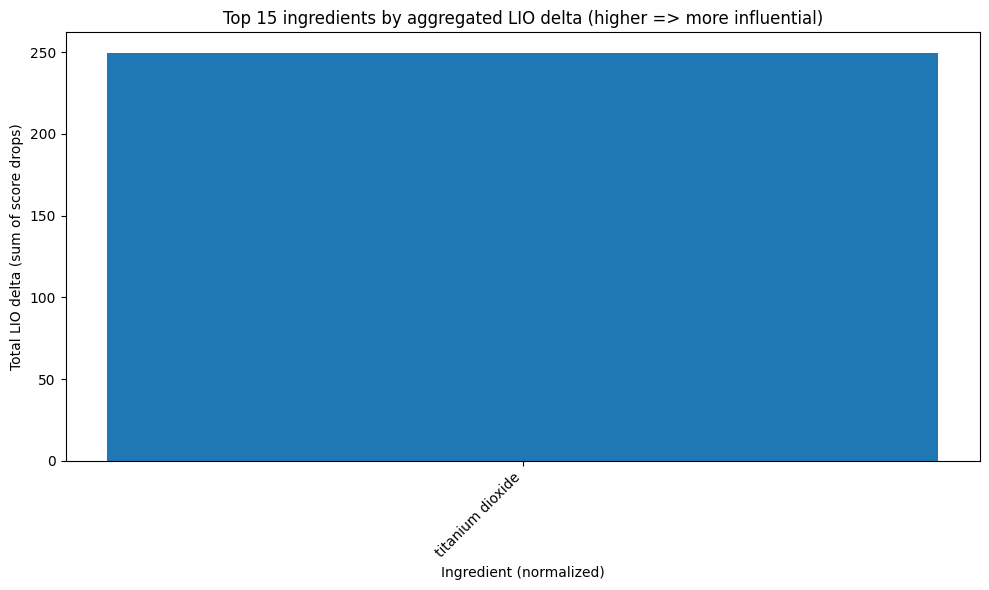

In [26]:
# Cell 2: plot top-N ingredients by total_delta using matplotlib
import matplotlib.pyplot as plt
import numpy as np

TOP_PLOT = 15   # change to plot more/less
top_df = summary.head(TOP_PLOT).copy()
if top_df.shape[0] == 0:
    raise RuntimeError("No aggregated LIO data found. Run aggregation cell first.")

plt.figure(figsize=(10, 6))
y = top_df['total_delta'].values
x = np.arange(len(y))
plt.bar(x, y)   # no explicit colors
plt.xticks(x, top_df['ingredient'].tolist(), rotation=45, ha='right')
plt.xlabel('Ingredient (normalized)')
plt.ylabel('Total LIO delta (sum of score drops)')
plt.title(f'Top {TOP_PLOT} ingredients by aggregated LIO delta (higher => more influential)')
plt.tight_layout()

# Save figure to Drive
fig_path = out_dir / f"top_{TOP_PLOT}_ingredients_total_delta.png"
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
print("Saved plot to:", fig_path)
plt.show()


In [27]:
# Cell 1: load processed outputs we saved earlier
import pandas as pd
from pathlib import Path
base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"
processed_dir = Path(base) / "processed"
lio_dir = Path(base) / "lio_results"

print("paths:")
print("processed_dir:", processed_dir)
print("lio_dir:", lio_dir)

chem_labels_f = processed_dir / "chemical_labels_from_main.csv"
prod_flags_f = processed_dir / "product_level_flags.csv"
lio_summary_f = lio_dir / "lio_summary_topK.csv"
global_summary_f = lio_dir / "global_ingredient_importance_summary.csv"

for f in [chem_labels_f, prod_flags_f, lio_summary_f, global_summary_f]:
    print(f, "exists?", f.exists())

chem = pd.read_csv(chem_labels_f) if chem_labels_f.exists() else None
prod = pd.read_csv(prod_flags_f) if prod_flags_f.exists() else None
lio_summary = pd.read_csv(lio_summary_f) if lio_summary_f.exists() else None
global_summary = pd.read_csv(global_summary_f) if global_summary_f.exists() else None

print("\nShapes:")
print("chem:", None if chem is None else chem.shape)
print("prod:", None if prod is None else prod.shape)
print("lio_summary:", None if lio_summary is None else lio_summary.shape)
print("global_summary:", None if global_summary is None else global_summary.shape)

# show small samples for quick inspection
if chem is not None: display(chem.head(6))
if prod is not None: display(prod.head(6))
if lio_summary is not None: display(lio_summary.head(6))
if global_summary is not None: display(global_summary.head(6))


paths:
processed_dir: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed
lio_dir: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results
/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/chemical_labels_from_main.csv exists? True
/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/product_level_flags.csv exists? True
/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/lio_summary_topK.csv exists? True
/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/global_ingredient_importance_summary.csv exists? True

Shapes:
chem: (157, 16)
prod: (34796, 7)
lio_summary: (50, 8)
global_summary: (1, 5)


,chemical_name_raw,chemical_name_norm,cas,label_prop65_exact_cas,label_iarc_exact_cas,label_toxcast_exact_cas,label_prop65_exact_name,label_iarc_exact_name,label_toxcast_exact_name,flag_exact_any,fuzzy_match_name,fuzzy_score,label_fuzzy_any,flag_any,matching_source,occurrences
0,Titanium dioxide,titanium dioxide,13463-67-7,False,True,False,False,False,False,True,NaN,NaN,False,True,exact,92304
1,Distillates (coal tar),distillates (coal tar),65996-92-1,False,False,False,False,False,False,False,NaN,0.0,False,False,none,1
2,Estragole,estragole,140-67-0,True,False,True,False,False,True,True,NaN,NaN,False,True,exact,155
3,Cocamide diethanolamine,cocamide diethanolamine,68603-42-9,False,True,False,False,False,False,True,NaN,NaN,False,True,exact,1397
4,Toluene,toluene,108-88-3,True,True,False,False,False,False,True,NaN,NaN,False,True,exact,63
5,Cocamide diethanolamine,cocamide diethanolamine,NaN,False,False,False,False,False,False,False,NaN,0.0,False,False,none,1397


,_product_id,product_name,brand,num_ingredients,count_flagged,fraction_flagged,product_label
0,Anastasia Beverly HIlls||Perfect Brow Pencil (Granite shade_,Perfect Brow Pencil (Granite shade_,Anastasia Beverly HIlls,1,5,5.0,1
1,Entity Nudite||Cool Pink Nail Sculpting Powder,Cool Pink Nail Sculpting Powder,Entity Nudite,1,5,5.0,1
2,"Gap Outlet||Light Pink, lip gloss (Lip trio)","Light Pink, lip gloss (Lip trio)",Gap Outlet,1,5,5.0,1
3,Hard Candy||Fierce Effects- Shadow Duo,Fierce Effects- Shadow Duo,Hard Candy,1,100,100.0,1
4,Innisfree ||Innisfree My Lip Balm 05 Wild Hibiscus,Innisfree My Lip Balm 05 Wild Hibiscus,Innisfree,1,5,5.0,1
5,Laneige ||BB Cushion Pore Blur No.11 Porcelain,BB Cushion Pore Blur No.11 Porcelain,Laneige,1,10,10.0,1


,agg_index,product_id,brand,product_name,orig_score,num_ingredients,count_flagged,top_contributors_summary
0,22792,OPI Nail Lacquer||Conquisadorable Color,OPI Nail Lacquer,Conquisadorable Color,0.999964,1,5,titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987
1,22784,OPI Nail Lacquer||Canadian Maple Leaf,OPI Nail Lacquer,Canadian Maple Leaf,0.999964,1,5,titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987
2,22785,OPI Nail Lacquer||Canberra't without You,OPI Nail Lacquer,Canberra't without You,0.999964,1,5,titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987
3,22786,OPI Nail Lacquer||Cancun Fiesta,OPI Nail Lacquer,Cancun Fiesta,0.999964,1,5,titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987
4,22787,OPI Nail Lacquer||Charged Up Cherry,OPI Nail Lacquer,Charged Up Cherry,0.999964,1,5,titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987
5,22788,OPI Nail Lacquer||Chocolate Moose,OPI Nail Lacquer,Chocolate Moose,0.999964,1,5,titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987; titanium dioxide|flag=True|d=0.9987


,ingredient,total_delta,mean_delta,count,flagged_count
0,titanium dioxide,249.672607,0.99869,250,250


In [28]:
# Cell 2: dataset stats and CAS / fuzzy coverage
def summarize_dataset(chem_df, prod_df):
    print("=== Chemical-level summary ===")
    print("unique chemical rows:", len(chem_df))
    if 'cas' in chem_df.columns:
        cas_nonnull = chem_df['cas'].notna().sum()
        print("CAS non-null:", cas_nonnull, f"({cas_nonnull/len(chem_df):.2%})")
    if 'flag_any' in chem_df.columns:
        flagged = chem_df['flag_any'].sum()
        print("Chemicals flagged (exact or fuzzy):", flagged, f"({flagged/len(chem_df):.2%})")
    if 'fuzzy_score' in chem_df.columns:
        fuzz_pct = chem_df['fuzzy_score'].notna().sum()
        print("Fuzzy matched rows:", fuzz_pct)
    print("\n=== Product-level summary ===")
    print("unique products:", len(prod_df))
    if 'product_label' in prod_df.columns:
        pos = prod_df['product_label'].sum()
        print("Positive products:", pos, f"({pos/len(prod_df):.2%})")
    print("num_ingredients stats:")
    print(prod_df['num_ingredients'].describe())
    print("fraction_flagged stats:")
    print(prod_df['fraction_flagged'].describe())

summarize_dataset(chem, prod)


=== Chemical-level summary ===
unique chemical rows: 157
CAS non-null: 111 (70.70%)
Chemicals flagged (exact or fuzzy): 110 (70.06%)
Fuzzy matched rows: 71

=== Product-level summary ===
unique products: 34796
Positive products: 33822 (97.20%)
num_ingredients stats:
count    34796.000000
mean         1.133090
std          0.407173
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: num_ingredients, dtype: float64
fraction_flagged stats:
count    34796.000000
mean        12.600629
std         42.115608
min          0.000000
25%          5.000000
50%          5.000000
75%          5.000000
max       3830.000000
Name: fraction_flagged, dtype: float64


Looking for saved models in: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/trained_models
models exist: False
Saved models not found; using in-memory objects if present. If none, please run training cells first.
Overall AUROC: 1.0000 | AUPRC: 1.0000 | Brier: 0.0000


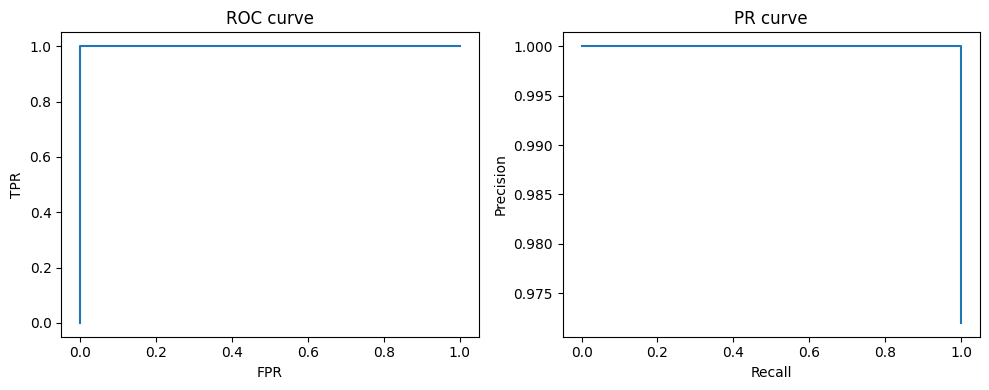

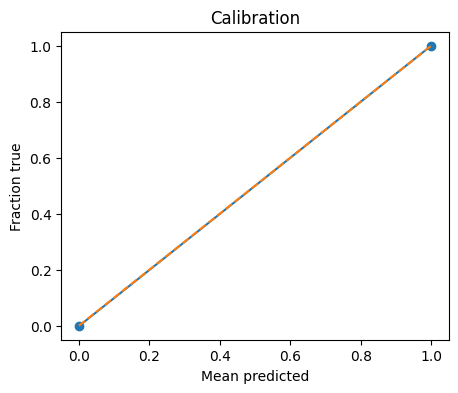

Saved predictions to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/predictions_and_labels.csv


In [29]:
# Cell 3: model metrics, PR/ROC, calibration curve
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
import joblib
import glob

# try to load models from drive if saved; fallback to previously defined clf_xgb in memory
model_path = Path(base) / "trained_models"
xgb_f = model_path / "clf_xgb.joblib"
lr_f = model_path / "clf_lr.joblib"
tfidf_f = model_path / "tfidf.joblib"
scaler_f = model_path / "scaler.joblib"

print("Looking for saved models in:", model_path)
model_exists = xgb_f.exists() and tfidf_f.exists() and scaler_f.exists()
print("models exist:", model_exists)

if model_exists:
    clf_xgb = joblib.load(xgb_f)
    tfidf = joblib.load(tfidf_f)
    scaler = joblib.load(scaler_f)
    print("Loaded artifacts.")
else:
    print("Saved models not found; using in-memory objects if present. If none, please run training cells first.")

# Build X_all again
prod['product_text'] = (prod['product_name'].fillna('') + " " + prod['brand'].fillna('')).str.strip()
from sklearn.feature_extraction.text import TfidfVectorizer
# If tfidf in memory use it else fit a new small one
if 'tfidf' not in globals():
    tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=2)
    X_text = tfidf.fit_transform(prod['product_text'].values)
else:
    X_text = tfidf.transform(prod['product_text'].values)

num_feat_names = ['num_ingredients','count_flagged','fraction_flagged']
if 'scaler' not in globals():
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_num = scaler.fit_transform(prod[num_feat_names].fillna(0).values)
else:
    X_num = scaler.transform(prod[num_feat_names].fillna(0).values)

X_all = hstack([X_text, csr_matrix(X_num)], format='csr')
y = prod['product_label'].values

# get predicted probabilities
if 'clf_xgb' in globals():
    probs = clf_xgb.predict_proba(X_all)[:,1]
elif model_exists:
    probs = clf_xgb.predict_proba(X_all)[:,1]
else:
    raise RuntimeError("No model found in memory or saved. Run training cell to get clf_xgb.")

# metrics
auc = roc_auc_score(y, probs) if len(np.unique(y))>1 else np.nan
auprc = average_precision_score(y, probs) if len(np.unique(y))>1 else np.nan
brier = brier_score_loss(y, probs)
print(f"Overall AUROC: {auc:.4f} | AUPRC: {auprc:.4f} | Brier: {brier:.4f}")

# ROC/PR curves
from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, _ = roc_curve(y, probs)
prec, rec, _ = precision_recall_curve(y, probs)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curve')
plt.subplot(1,2,2)
plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR curve')
plt.tight_layout()
plt.show()

# Calibration curve
prob_true, prob_pred = calibration_curve(y, probs, n_bins=10)
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--'); plt.xlabel('Mean predicted'); plt.ylabel('Fraction true'); plt.title('Calibration')
plt.show()

# Save a small CSV with probs + true label for inspection
out = Path(base) / "processed" / "predictions_and_labels.csv"
pd.DataFrame({'product_index': list(range(len(probs))),'product_label':y,'pred_prob':probs}).to_csv(out,index=False)
print("Saved predictions to:", out)
